In [ ]:
pip install deepxde


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.8/179.8 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.7/107.7 kB 10.1 MB/s eta 0:00:00


In [ ]:
# Import necessary libraries
import deepxde as dde  # Deep learning framework for solving differential equations
import matplotlib.pyplot as plt  # For creating static, animated, and interactive visualizations in Python
import numpy as np  # For numerical operations
from deepxde.backend import tf  # Tensorflow backend for DeepXDE
import matplotlib.animation as animation  # For creating animations
from matplotlib.animation import (
    FuncAnimation,
)  # Function-based interface to create animations
import argparse

Compiling model...
Building feed-forward neural network...
'build' took 0.117686 s



/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 2.717447 s

Training model...

Step      Train loss                                                                Test loss                                                                 Test metric
0         [1.14e-02, 6.72e-03, 4.39e-03, 8.53e-01, 9.21e-03, 2.65e-02, 4.85e-02]    [1.14e-02, 6.72e-03, 4.39e-03, 8.53e-01, 9.21e-03, 2.65e-02, 4.85e-02]    []  
1000      [5.09e-04, 6.29e-05, 1.95e-04, 7.00e-03, 3.68e-05, 2.69e-05, 9.95e-03]    [5.09e-04, 6.29e-05, 1.95e-04, 7.00e-03, 3.68e-05, 2.69e-05, 9.95e-03]    []  
2000      [2.41e-04, 4.86e-05, 3.73e-05, 5.25e-03, 3.81e-05, 4.08e-06, 1.42e-04]    [2.41e-04, 4.86e-05, 3.73e-05, 5.25e-03, 3.81e-05, 4.08e-06, 1.42e-04]    []  
3000      [2.97e-04, 3.94e-05, 1.29e-05, 4.62e-03, 2.08e-05, 3.47e-06, 8.85e-05]    [2.97e-04, 3.94e-05, 1.29e-05, 4.62e-03, 2.08e-05, 3.47e-06, 8.85e-05]    []  
4000      [5.67e-05, 1.27e-05, 1.30e-05, 1.88e-03, 1.32e-05, 2.63e-06, 5.63e-06]    [5.67e-05, 1.27e-05, 1.30e-05, 1.88e-03, 1.32e-0

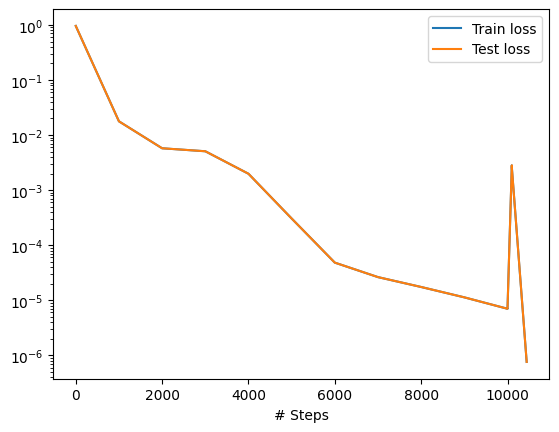

AttributeError: 'list' object has no attribute 'reshape'

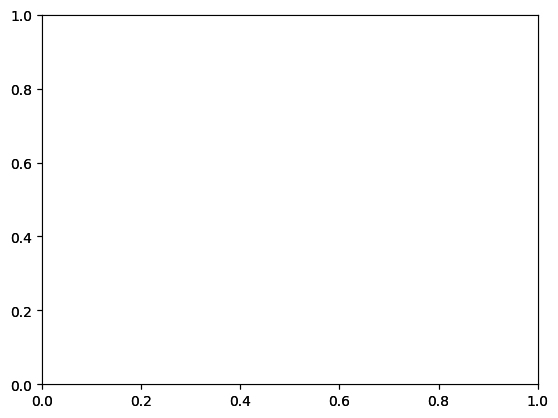

In [ ]:

# parser = argparse.ArgumentParser(description='Heat2D simulation with variable ALPHA.')
# parser.add_argument('alpha', type=float, help='Value of ALPHA')
# args = parser.parse_args()

# Constants/Network Parameters
SAMPLE_POINTS = 2000
T_START = 0
T_END = WIDTH = LENGTH = 1.0
ALPHA = 0.10
ARCHITECTURE = (
    [3] + [60] * 5 + [1]
)  # Network architecture ([input_dim, hidden_layer_1_dim, ..., output_dim])
ACTIVATION = "tanh"  # Activation function
INITIALIZER = "Glorot uniform"  # Weights initializer
LEARNING_RATE = 1e-3  # Learning rate
LOSS_WEIGHTS = [
    10,
    1,
    1,
    1,
    1,
    1,
    10,
]  # Weights for different components of the loss function
ITERATIONS = 10000  # Number of training iterations
OPTIMIZER = "adam"  # Optimizer for the first part of the training
BATCH_SIZE = 32  # Batch size

nu = 0.3
# Define PDEs
def pdes(X, y):
     U, V = y[:, 0:1], y[:, 0:1]

    # Gradients for U
     U_xx = dde.grad.hessian(U, X, i=0, j=0)
     U_yy = dde.grad.hessian(U, X, i=1, j=1)

    # Gradients for V
     V_xx = dde.grad.hessian(V, X, i=0, j=0)
     V_yy = dde.grad.hessian(V, X, i=1, j=1)

    # Mixed derivatives
     U_xy = dde.grad.hessian(U, X, i=0, j=1)
     V_xy = dde.grad.hessian(V, X, i=0, j=1)

    # Equations
     equation1 = U_xx + (1 - nu) / 2 * U_yy + (1 + nu) / 2 * V_xy
     equation2 = V_yy + (1 - nu) / 2 * V_xx + (1 + nu) / 2 * U_xy

     return [equation1, equation2]

# Define boundary conditions
def boundary_right(X, on_boundary):
    x, _, _ = X
    return on_boundary and np.isclose(x, WIDTH)  # Check if on the right boundary


def boundary_left(X, on_boundary):
    x, _, _ = X
    return on_boundary and np.isclose(x, 0)  # Check if on the left boundary


def boundary_top(X, on_boundary):
    _, y, _ = X
    return on_boundary and np.isclose(y, LENGTH)  # Check if on the upper boundary


def boundary_bottom(X, on_boundary):
    _, y, _ = X
    return on_boundary and np.isclose(y, 0)  # Check if on the lower boundary


# Define initial condition
def boundary_initial(X, on_initial):
    _, _, t = X
    return on_initial and np.isclose(t, 0)  # Check if at the initial time


# Initialize a function for the temperature field
def init_func(X):
    t = np.zeros((len(X), 1))  # Temperature is zero everywhere at the T_START
    return t


# Define Dirichlet and Neumann boundary conditions
def constraint_right(X):
    return np.ones((len(X), 1))  # On the right boundary, temperature is kept at 1


def func_zero(X):
    return np.zeros(
        (len(X), 1)
    )  # On the other boundaries, the derivative of temperature is kept at 0 (Neumann condition)


# Define geometry and time domains
geom = dde.geometry.Rectangle([0, 0], [WIDTH, LENGTH])  # Geometry domain
timedomain = dde.geometry.TimeDomain(0, T_END)  # Time domain
geomtime = dde.geometry.GeometryXTime(geom, timedomain)  # Space-time domain

# Define boundary conditions and initial condition
bc_l = dde.NeumannBC(geomtime, func_zero, boundary_left)  # Left boundary
bc_r = dde.DirichletBC(geomtime, constraint_right, boundary_right)  # Right boundary
bc_up = dde.NeumannBC(geomtime, func_zero, boundary_top)  # Upper boundary
bc_low = dde.NeumannBC(geomtime, func_zero, boundary_bottom)  # Lower boundary
ic = dde.IC(geomtime, init_func, boundary_initial)  # Initial condition

# Define data for the PDE
data = dde.data.TimePDE(
    geomtime,
    pdes,
    [bc_l, bc_r, bc_up, bc_low, ic],
    num_domain=int(SAMPLE_POINTS),
    num_boundary=int(SAMPLE_POINTS / 4),
    num_initial=int(SAMPLE_POINTS / 2),
)

# Define the neural network model
net = dde.maps.FNN(ARCHITECTURE, ACTIVATION, INITIALIZER)  # Feed-forward neural network
net.apply_output_transform(lambda _, y: abs(y))
model = dde.Model(data, net)  # Create the model

# Compile the model with the chosen optimizer, learning rate and loss weights
model.compile(OPTIMIZER, lr=LEARNING_RATE, loss_weights=LOSS_WEIGHTS)
# Train the model
losshistory, trainstate = model.train(
    iterations=ITERATIONS,
    batch_size=BATCH_SIZE,
)

# Residual Adaptive Refinement (RAR)
X = geomtime.random_points(1000)
y = geomtime.random_points(1000)
err = 1
while err > 0.01:
    f = model.predict(y, operator=pdes)
    err_eq = np.absolute(f)
    err = np.mean(err_eq)
    print("Mean residual: %.3e" % (err))
    x_id = np.argmax(err_eq)
    print("Adding new point:", X[x_id], "\n")
    data.add_anchors(X[x_id])
    # Stop training if the model isn't learning anymore
    early_stopping = dde.callbacks.EarlyStopping(min_delta=1e-4, patience=2000)
    model.compile(OPTIMIZER, lr=LEARNING_RATE, loss_weights=LOSS_WEIGHTS)
    model.train(
        iterations=100, disregard_previous_best=True, batch_size=BATCH_SIZE, callbacks=[early_stopping]
    )
    model.compile("L-BFGS-B")
    dde.optimizers.set_LBFGS_options(
        maxcor=100,
    )
    losshistory, train_state = model.train(batch_size=BATCH_SIZE,)


model.save("./trained_PINN_model")

dde.saveplot(losshistory, trainstate, issave=True, isplot=True)
plt.show()
plt.savefig("loss_history_plot_Heat2d")
plt.close()

# Predict the solution at different time points and create an animation
fig, ax = plt.subplots()
ax = fig.add_subplot(111)

# Set up the grid
nelx = 100  # Number of elements in x direction
nely = 100  # Number of elements in y direction
timesteps = 101  # Number of time steps
x = np.linspace(0, 1, nelx + 1)  # x coordinates
y = np.linspace(0, 1, nely + 1)  # y coordinates
t = np.linspace(0, 1, timesteps)  # Time points

# Prepare the data for the prediction
test_x, test_y, test_t = np.meshgrid(x, y, t)
test_domain = np.vstack((np.ravel(test_x), np.ravel(test_y), np.ravel(test_t))).T

# Predict Solution and Residual
predicted_solution = model.predict(test_domain)
predicted_solution = predicted_solution.reshape(
    test_x.shape
)  # Scale and reshape solution
residual = model.predict(test_domain, operator=pdes)
residual = residual.reshape(test_x.shape)  # Reshape residuals


# Animation function
def animate_solution(data, filename, title, label, t_data):
    fig, ax = plt.subplots(figsize=(7, 7))

    # Create initial image and colorbar
    im = ax.imshow(
        data[:, :, 0],
        origin="lower",
        cmap="jet",
        interpolation="bilinear",
        extent=[0, 1, 0, 1],
    )
    cb = plt.colorbar(im, ax=ax, label=label)
    ax.set_xlabel("x")
    ax.set_ylabel("y")

    # Update function for the frames
    def updatefig(k):
        # Update image data
        im.set_array(data[:, :, k])
        im.set_clim(
            vmin=data[:, :, k].min(), vmax=data[:, :, k].max()
        )  # Update the color limits

        # Update colorbar
        cb.update_normal(im)

        # Update title
        ax.set_title(f"{title}, t = {t_data[k]:.2f}")

        return [im]

    ani = animation.FuncAnimation(
        fig, updatefig, frames=range(data.shape[2]), interval=50, blit=True
    )
    ani.save(filename, writer="ffmpeg")


# Create and save the solution animation
animate_solution(
    predicted_solution,
    f"pinn_heat2d_solution_alpha_{str(ALPHA)}.mp4",
    "Diffusion Equation",
    "Temperature (K)",
    t,
)

# Create and save the residuals animation
animate_solution(
    residual,
    f"pinn_heat2d_residual_{str(ALPHA)}.mp4",
    "Residual",
    "Residual",
    t,
)
